# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd

from dataloader.load_regression_data import RegressionDataGenerator

from utils.gaussian_processes.gp_model import GPModel
from utils.get_dummy_data.get_data_from_function import get_df_from_1d_function, split_train_test

2023-02-21 12:08:03.156204: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 12:08:03.410102: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-21 12:08:03.410126: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-21 12:08:03.461863: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-21 12:08:04.637662: W tensorflow/stream_executor/pla

# Data

In [2]:
def fct(x):
    return np.sin(3*x) + 2 * x

x_arr = np.linspace(0, 10, 100)

In [3]:
df = get_df_from_1d_function(fct, x_arr)
x_col = "x"
y_col = "y"

df.head()

,x,y
0,0.00000,0.000000
1,0.10101,0.500434
2,0.20202,0.973675
3,0.30303,1.395006
4,0.40404,1.744444


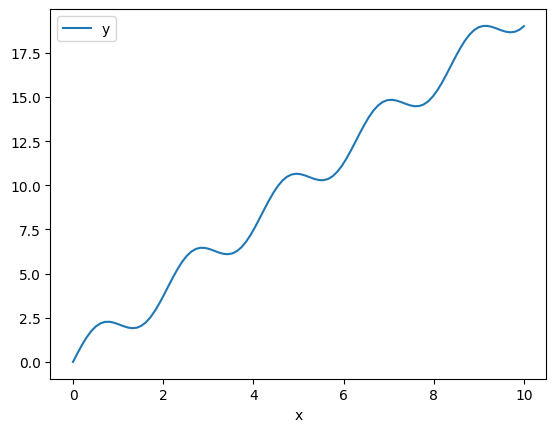

In [4]:
df.plot(x=x_col, y=y_col);

In [5]:
df_observed, df_predict = split_train_test(df, frac=0.5)

In [6]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 98
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       50 non-null     float64
 1   y       50 non-null     float64
dtypes: float64(2)
memory usage: 1.2 KB


# Gaussian Process

In [7]:
gp_model = GPModel()
gp_model.fit(df_observed=df_observed, x_col=x_col, y_col=y_col, epochs=1000)

2023-02-21 12:08:07.704510: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-21 12:08:07.704561: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-21 12:08:07.704591: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2023-02-21 12:08:07.704886: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
  0%|          | 0/1000 [00:00<?, ?it/s]

Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.


loss = 85.420: 100%|██████████| 1000/1000 [00:29<00:00, 34.25it/s]


# DataGenerator

In [8]:
data_generator = RegressionDataGenerator(gp_model=gp_model,
                                         df_predict=df_predict)

(<Figure size 800x500 with 1 Axes>, <AxesSubplot: >)

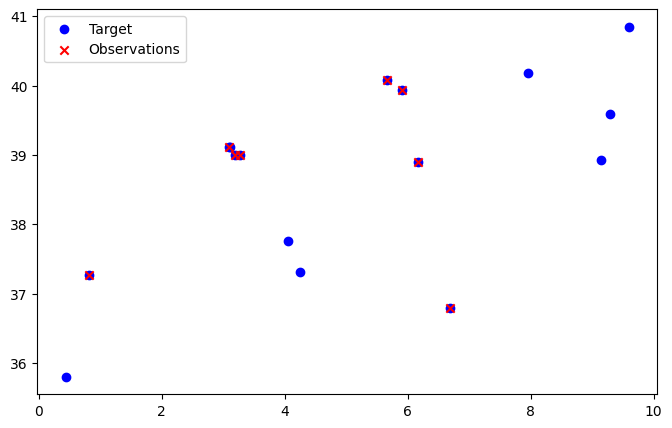

In [9]:
data_generator.plot_first_elt_of_random_batch()

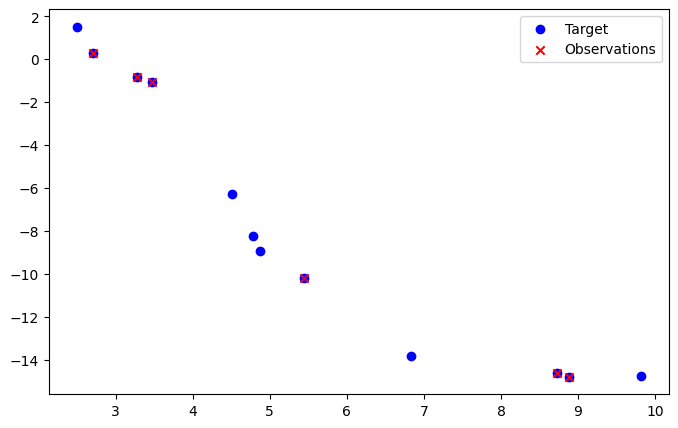

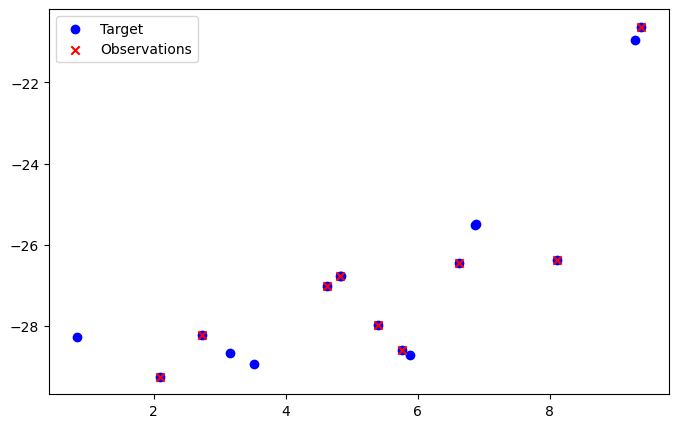

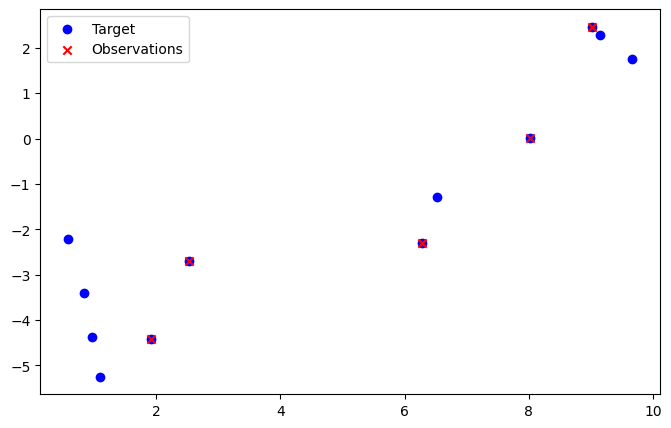

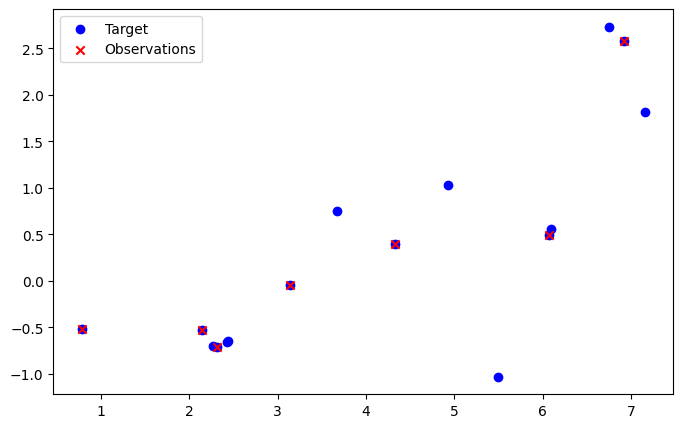

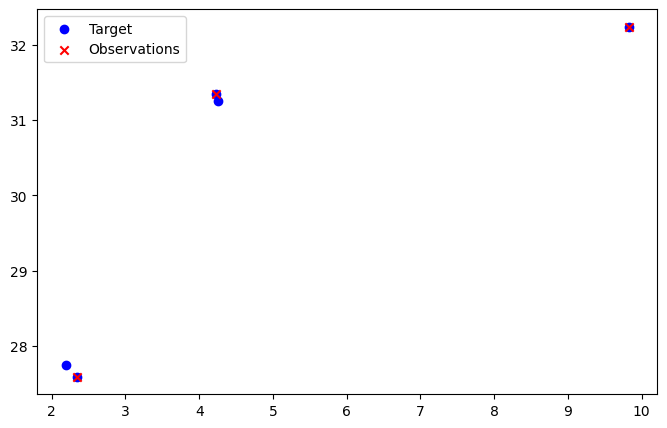

In [10]:
for (context_x, context_y, target_x), target_y in data_generator.train_ds.take(5):
    RegressionDataGenerator.plot_first_elt_of_batch(context_x, context_y, target_x, target_y)

# Conditional Neural Process

In [11]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from model import ConditionalNeuralProcess
from utils.gaussian_processes.plot_gp_utils import plot_preds_from_ds_test
from utils.plot import plot_learning_curve

encoder_dims = [500, 500, 500, 500]
decoder_dims = [500, 500, 500, 2]

def loss(target_y, pred_y):
    # Get the distribution
    mu, sigma = tf.split(pred_y, num_or_size_splits=2, axis=-1)
    dist = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
    return -dist.log_prob(target_y)

model = ConditionalNeuralProcess(encoder_dims, decoder_dims)
model.compile(loss=loss, optimizer='adam')

In [12]:
history = model.fit(data_generator.train_ds, validation_data=data_generator.test_ds, epochs=1)

      4/Unknown - 4s 615ms/step - loss: 74.8980WARNING:tensorflow:5 out of the last 5 calls to <function ConditionalNeuralProcess.call at 0x7f3725622cb0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
      5/Unknown - 5s 636ms/step - loss: 60.6918WARNING:tensorflow:6 out of the last 6 calls to <function ConditionalNeuralProcess.call at 0x7f3725622cb0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.f

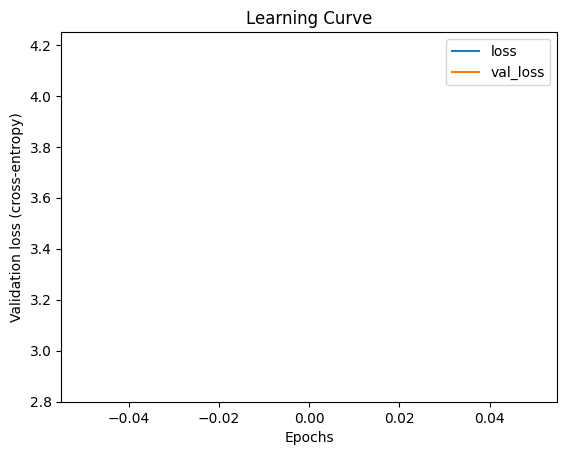

In [13]:
plot_learning_curve(history)

1/1 [==============================] - 0s 224ms/step


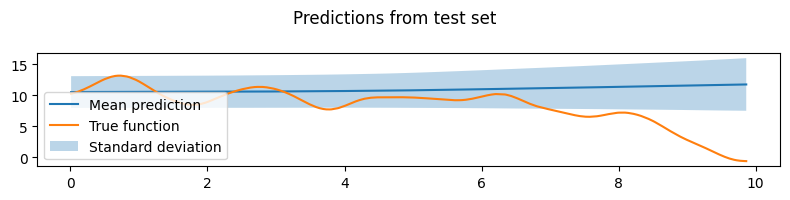

In [14]:
fig = plot_preds_from_ds_test(model, ds_test=data_generator.test_ds, num_samples=1)

1/1 [==============================] - 0s 171ms/step


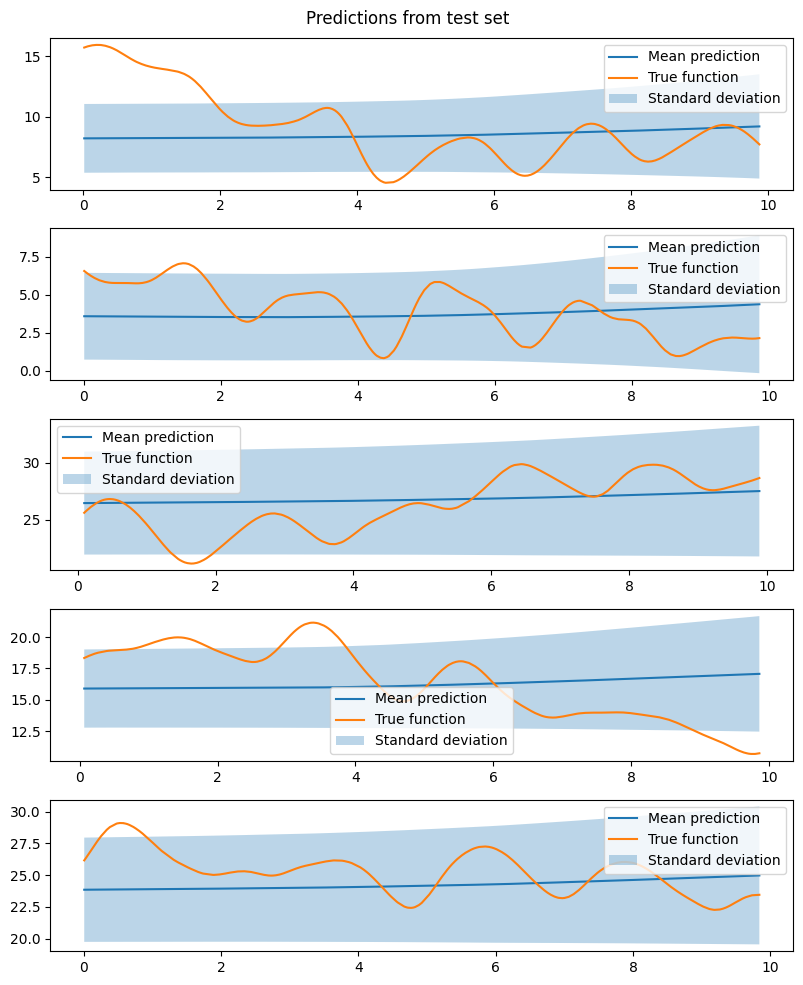

In [15]:
fig = plot_preds_from_ds_test(model, ds_test=data_generator.test_ds, num_samples=5)